In [1]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd


In [2]:
class ContrastiveMedicalMNISTData(Dataset) : 
    def __init__(self,root,transform=None) :
        self.dataset=ImageFolder(root=root)
        self.transform = transform
        if self.transform is None:
            raise ValueError("Transform must be provided and include ToTensor()")        
    def __len__(self) : 
        return len(self.dataset )
    def __getitem__(self,idx):
        img, label = self.dataset[idx]

        # apply transform safely
        if self.transform:
            x1 = self.transform(img)
            x2 = self.transform(img)


        return x1, x2, label 
        

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
])


In [4]:
path = r'/kaggle/input/medical-mnist-train-test-val/train'

dataset= ContrastiveMedicalMNISTData(root  = path , transform=transform)
print("✅ Dataset loaded successfully!")
print(f"Total images: {len(dataset)}")
print("Classes:", dataset.dataset.classes)


✅ Dataset loaded successfully!
Total images: 47163
Classes: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


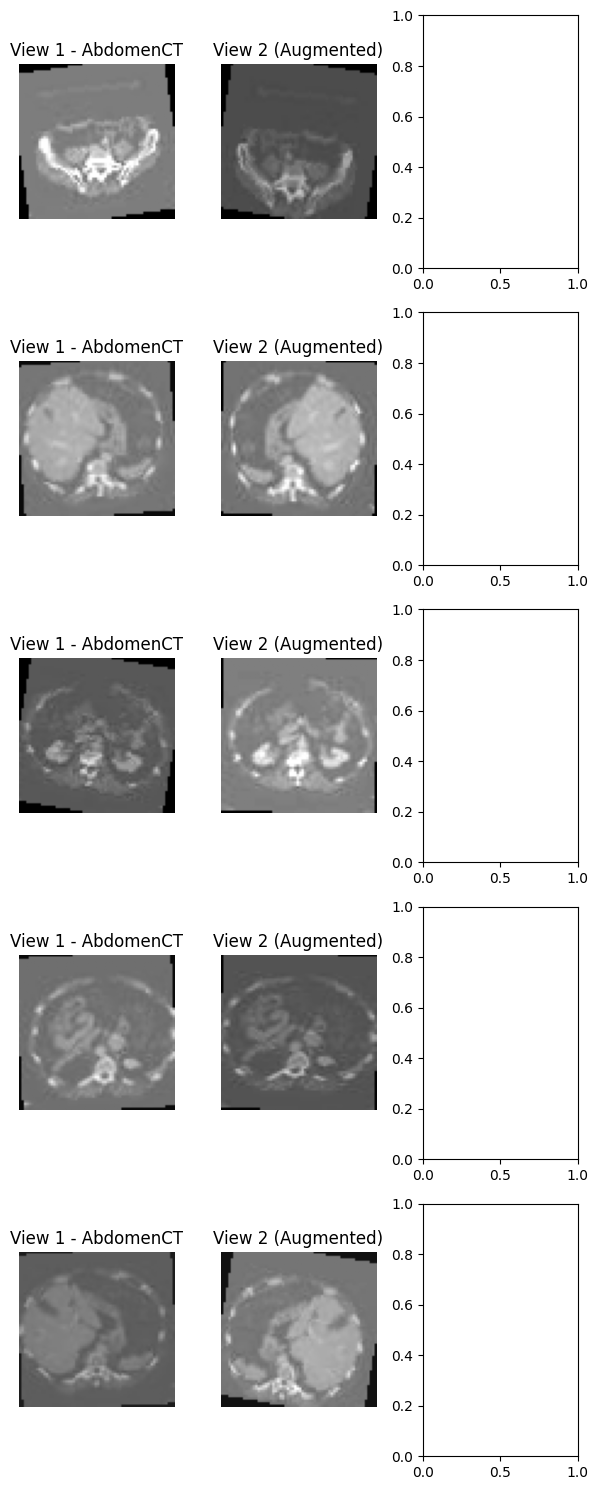

In [5]:
def show_pairs(dataset, n=5):
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(6, n*3))
    
    for i in range(n):
        x1, x2, label = dataset[i+1000]
        axes[i, 0].imshow(x1.permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 0].set_title(f'View 1 - {dataset.dataset.classes[label]}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(x2.permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 1].set_title('View 2 (Augmented)')
        axes[i, 1].axis('off')

        

    plt.tight_layout()
    plt.show()

show_pairs(dataset, n=5)

In [6]:
import torchvision.models as models
import torch.nn as nn

class Encoder(nn.Module) : 
    def __init__(self,) : 
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # remove lasFc
        self.backbone = nn.Sequential(*list(base.children())[:-1]) 
        self.projection = nn.Sequential(
            nn.Linear(512,128) ,
            nn.ReLU(),
            nn.Linear(128,64)
        )
    def forward(self,x) : 
        B=x.size(0)
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)
        features =self.backbone(x).view(B,-1)
        projection = self.projection(features)
        projection = F.normalize(projection, dim=1)
        return projection

In [7]:
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature=0.5):
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    z = F.normalize(z, dim=1)

    sim = torch.mm(z, z.t())
    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim = sim[~mask].view(2*B, -1)

    pos_sim = torch.sum(z1 * z2, dim=1) / temperature
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

    loss = -torch.log(torch.exp(pos_sim) / torch.sum(torch.exp(sim), dim=1))
    return loss.mean()


In [8]:
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = Encoder().to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    encoder.train()  # Set to training mode
    
    for batch_idx, (x1, x2, _) in enumerate(loader):
        x1, x2 = x1.to(device), x2.to(device)

        z1 = encoder(x1)
        z2 = encoder(x2)

        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # Print every 10 batches
        
        print(f"Epoch [{epoch+1}/{epochs}] | Batch [{batch_idx+1}/{len(loader)}] | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    print(f"{'='*60}")
    print(f"Epoch {epoch+1}/{epochs} Complete | Average Loss: {avg_loss:.4f}")
    print(f"{'='*60}\n")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


Epoch [1/5] | Batch [1/1474] | Loss: 3.3576
Epoch [1/5] | Batch [2/1474] | Loss: 3.1245
Epoch [1/5] | Batch [3/1474] | Loss: 2.9783
Epoch [1/5] | Batch [4/1474] | Loss: 2.7957
Epoch [1/5] | Batch [5/1474] | Loss: 2.7602
Epoch [1/5] | Batch [6/1474] | Loss: 2.5280
Epoch [1/5] | Batch [7/1474] | Loss: 2.4821
Epoch [1/5] | Batch [8/1474] | Loss: 2.4179
Epoch [1/5] | Batch [9/1474] | Loss: 2.4313
Epoch [1/5] | Batch [10/1474] | Loss: 2.4397
Epoch [1/5] | Batch [11/1474] | Loss: 2.3611
Epoch [1/5] | Batch [12/1474] | Loss: 2.3175
Epoch [1/5] | Batch [13/1474] | Loss: 2.3577
Epoch [1/5] | Batch [14/1474] | Loss: 2.3476
Epoch [1/5] | Batch [15/1474] | Loss: 2.2979
Epoch [1/5] | Batch [16/1474] | Loss: 2.3055
Epoch [1/5] | Batch [17/1474] | Loss: 2.3189
Epoch [1/5] | Batch [18/1474] | Loss: 2.3720
Epoch [1/5] | Batch [19/1474] | Loss: 2.3752
Epoch [1/5] | Batch [20/1474] | Loss: 2.3297
Epoch [1/5] | Batch [21/1474] | Loss: 2.2976
Epoch [1/5] | Batch [22/1474] | Loss: 2.3208
Epoch [1/5] | Batch

In [17]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

encoder.eval()

# pick 2 classes
classes_to_show = dataset.dataset.classes[:2]  # first 2 classes
num_per_class = 5

embeddings = []
labels = []
images = []

for lbl_idx, cls in enumerate(classes_to_show):
    count = 0
    for i in range(len(dataset)):
        _, _, lbl = dataset[i]
        if lbl != lbl_idx:
            continue
        if count >= num_per_class:
            break
        img1, _, _ = dataset[i]
        with torch.no_grad():
            emb = encoder(img1.unsqueeze(0).to(device))
        embeddings.append(emb.cpu())
        labels.append(lbl_idx)
        images.append(img1)
        count += 1

embeddings = torch.cat(embeddings, dim=0).numpy()
labels = np.array(labels)


In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(embeddings)


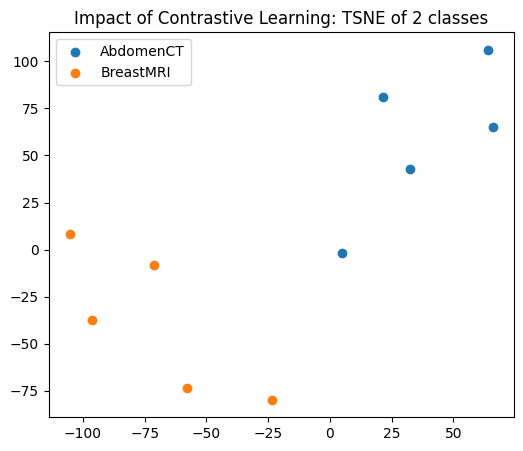

In [19]:
plt.figure(figsize=(6,5))
for lbl_idx, cls in enumerate(classes_to_show):
    idxs = labels == lbl_idx
    plt.scatter(emb_2d[idxs,0], emb_2d[idxs,1], label=cls)
plt.legend()
plt.title("Impact of Contrastive Learning: TSNE of 2 classes")
plt.show()


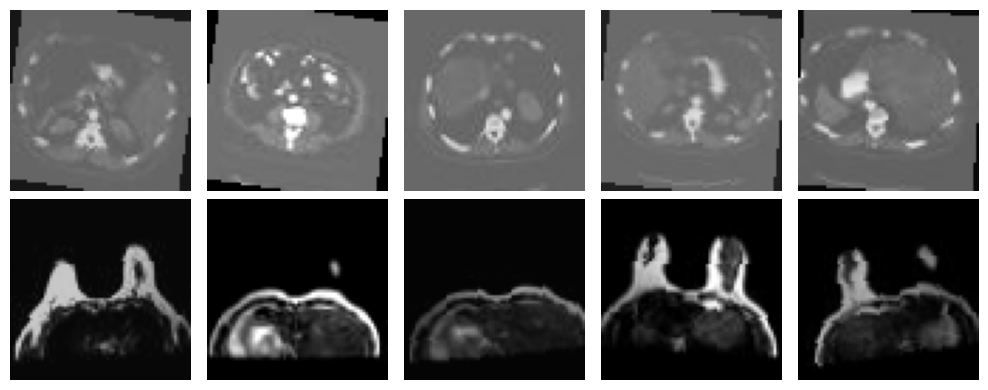

In [20]:
fig, axes = plt.subplots(len(classes_to_show), num_per_class, figsize=(num_per_class*2, len(classes_to_show)*2))
for i, lbl in enumerate(labels):
    ax = axes[labels[i], i % num_per_class] if len(classes_to_show) > 1 else axes[i]
    ax.imshow(images[i].permute(1,2,0))
    ax.axis('off')
plt.tight_layout()
plt.show()
